In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn import model_selection, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore the annoying warnings (from sklearn and seaborn)
color = sns.color_palette()
sns.set_style('darkgrid')

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train_copy = train.copy(deep = True)

data_cleaner = [train_copy, test]

print (train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#Checking for null values:

print('Train columns with null values:\n', train_copy.isnull().sum())
print("---------------")

print('Test columns with null values:\n', test.isnull().sum())
print("---------------")

train.describe(include = "all")

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------
Test columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
---------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Smiljanic, Mr. Mile",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


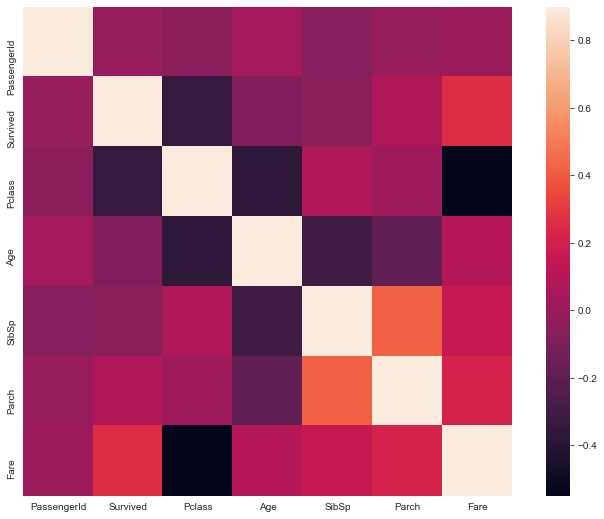

In [3]:
#Correlation map to see how features are correlated with Survived and with each other
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [4]:
#Filling in or removing missing values in train and test datasets
#Age and Pclass are most related, so will fill in Age with the median wrt. Pclass

for dataset in data_cleaner:
    #Age and Pclass are most related, so will group by Pclass and then get the median age
    dataset['Age'] = dataset.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))
    
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    
    #Fare and Pclass are most related, so once again groupby & get median
    dataset['Fare'] = dataset.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
#delete the useless columns
drop_column = ['PassengerId','Cabin', 'Ticket']
train_copy.drop(drop_column, axis=1, inplace = True)

print(train_copy.isnull().sum())
print("--------------")
print(test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
#Creating new features
for dataset in data_cleaner:    
    #Getting FamilySize from Sibling and Parent counts
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0

    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    
#Group rare title names into "Other"
stat_min = 10 
title_names = (train_copy['Title'].value_counts() < stat_min) 

train_copy['Title'] = train_copy['Title'].apply(lambda x: 'Other' if title_names.loc[x] == True else x)
print(train_copy['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64


In [6]:
#Converting data with Label Encoder

label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

#Defining the variable we want to predict
Target = ['Survived']

#Defining all the X (feature) variables that we want to select from
train_copy_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 
train_copy_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] 
train_copy_xy =  Target + train_copy_x
print('Original X Y: ', train_copy_xy, '\n')

##define x variables with bin features 
train_copy_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
train_copy_xy_bin = Target + train_copy_x_bin
print('Bin X Y: ', train_copy_xy_bin, '\n')


Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 



In [7]:
#train_test_split time

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(train_copy[train_copy_x_calc], train_copy[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(train_copy[train_copy_x_bin], train_copy[Target] , random_state = 0)

print("Data1 Shape: {}".format(train_copy.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,2,1,1,0
68,0,3,2,1,7,1,1
253,1,3,2,2,2,1,2
320,1,3,2,2,1,1,0
706,0,2,2,3,1,2,1


In [8]:
print('Train columns with null values: \n', train_copy.isnull().sum())
print("-"*10)
print (train_copy.info())
print("-"*10)

print('Test/Validation columns with null values: \n', test.isnull().sum())
print("-"*10)
print (test.info())
print("-"*10)

train.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Smiljanic, Mr. Mile",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

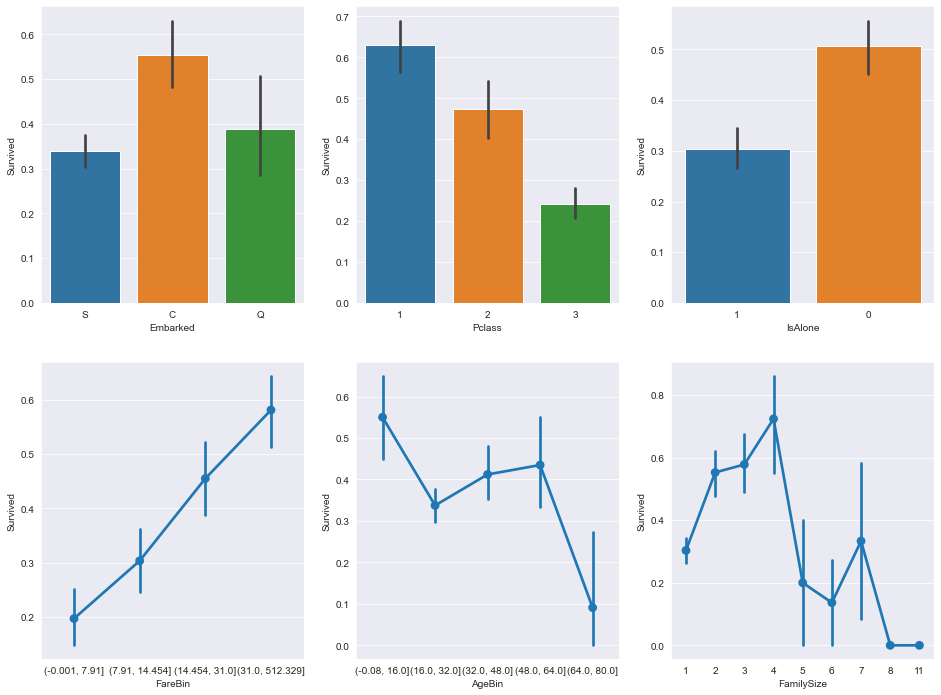

In [9]:
#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=train_copy, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=train_copy, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=train_copy, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=train_copy, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=train_copy, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=train_copy, ax = saxis[1,2])

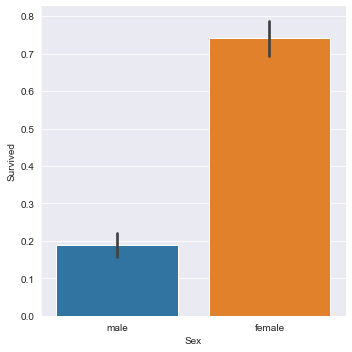

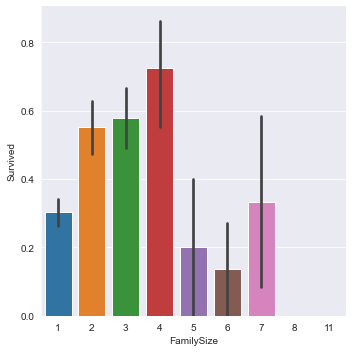

In [10]:
sns.catplot(x="Sex", y="Survived", kind="bar", data=train_copy)
sns.catplot(x="FamilySize", y="Survived", kind="bar", data=train_copy)

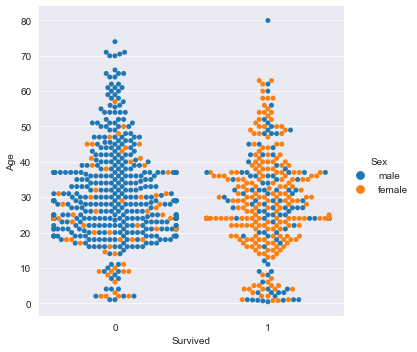

In [11]:
sns.catplot(x="Survived", y="Age", hue="Sex", kind="swarm", data=train_copy)

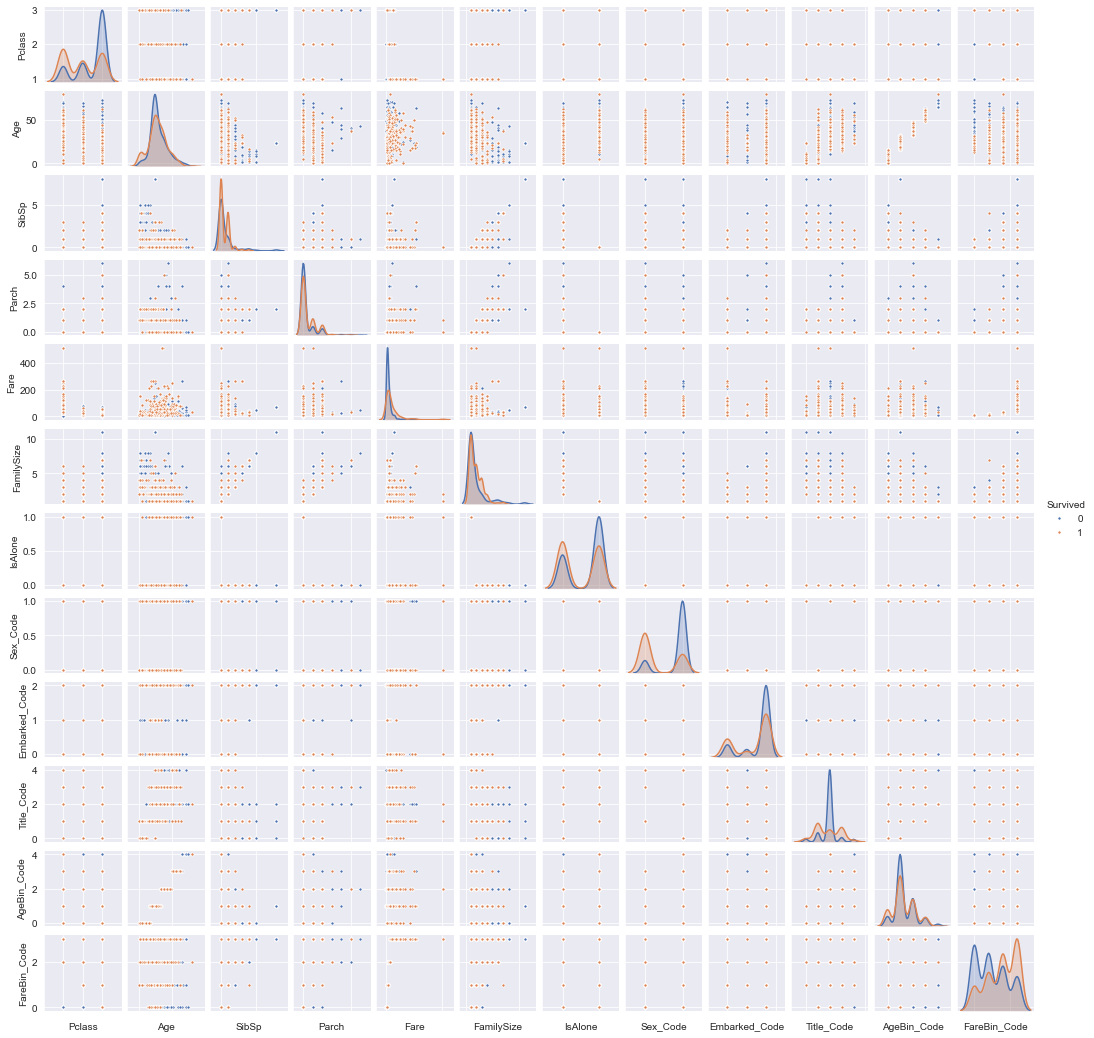

In [12]:
#ALL THE DATA!
pp = sns.pairplot(train_copy, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

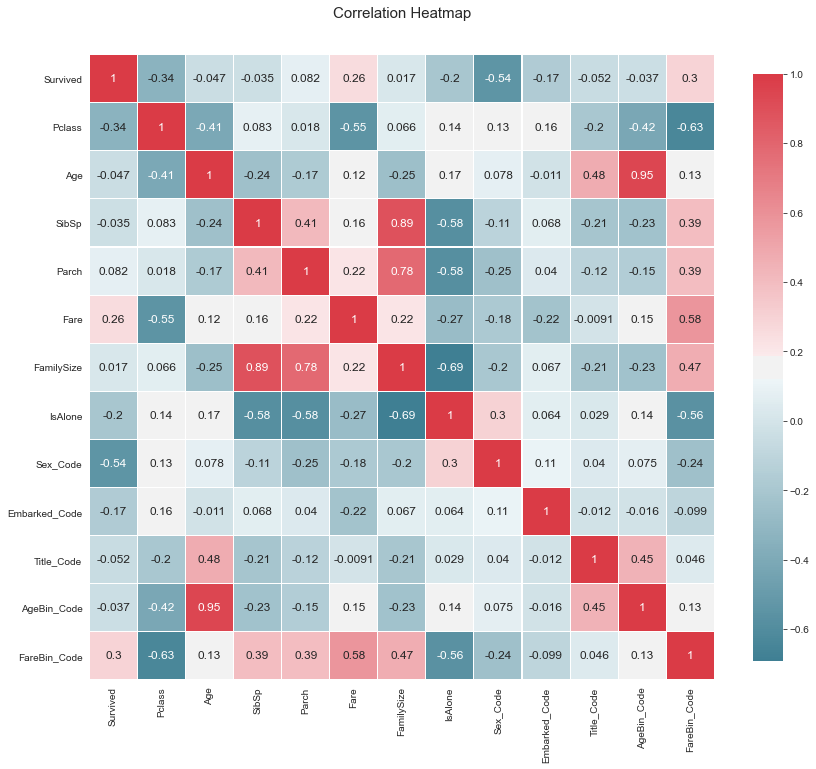

In [13]:
#correlation heatmap 
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Correlation Heatmap', y=1.05, size=15)

correlation_heatmap(train_copy)

In [14]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=6, random_state=0)
random_forest.fit(train_copy[train_copy_x_bin], train_copy[Target])
Y_pred = random_forest.predict(test[train_copy_x_bin])
test['Survived'] = Y_pred
random_forest.score(train_copy[train_copy_x_bin], train_copy[Target])
acc_random_forest = round(random_forest.score(train_copy[train_copy_x_bin], train_copy[Target]) * 100, 2)
acc_random_forest


<ipython-input-14-b6e7e338cf1c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(train_copy[train_copy_x_bin], train_copy[Target])


85.19

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

clf = make_pipeline(StandardScaler(), LinearSVC())
clf.fit(train_copy[train_copy_x_bin], train_copy[Target])
prediction = clf.predict(test[train_copy_x_bin])

test['Survived'] = prediction
clf.score(train_copy[train_copy_x_bin], train_copy[Target])
acc_clf = round(clf.score(train_copy[train_copy_x_bin], train_copy[Target]) * 100, 2)
acc_clf

79.57